In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotly import tools
import plotly.graph_objs as go
import plotly.offline as py
from plotly.offline import init_notebook_mode, iplot
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics


import warnings
warnings.filterwarnings("ignore")


In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.listdir('/content/drive/My Drive/big data project')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['test.csv', 'train.csv', 'sampleSubmission.csv', 'stores.csv', 'features.csv']

In [ ]:
train = pd.read_csv ('/content/drive/My Drive/big data project/train.csv')
test = pd.read_csv ('/content/drive/My Drive/big data project/test.csv')
stores = pd.read_csv ('/content/drive/My Drive/big data project/stores.csv')


In [ ]:
forcasting_df=test[['Store','Dept','Date'	,'IsHoliday']]
forcasting_train=train[['Store','Dept','Date'	,'IsHoliday']]

In [ ]:
train.head(2)

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


In [ ]:
test.head(2)

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False


In [ ]:
train.shape , test.shape 

((421570, 5), (115064, 4))

# **EDA**

In [ ]:
# Show an amount on sales in each year, store 
Overall_Weekly_sales = train.groupby('Date', as_index=False)['Weekly_Sales'].sum()
Overall_stores_sales = train.groupby(['Store', 'Date'], as_index=False)['Weekly_Sales'].sum()


In [ ]:
# Ilustrate Overall Weekly sales of Walmart
sales_plot = go.Scatter(x=Overall_Weekly_sales['Date'], y=Overall_Weekly_sales['Weekly_Sales'])
layout = go.Layout(title='Overall Weekly Sales of Walmart', xaxis=dict(title='Date'),
                   yaxis=dict(title='Weekly_Sales'))
fig = go.Figure(data=[sales_plot], layout=layout)
iplot(fig)

In [ ]:
# Find Dates from calendar: year,month,week and day
train['Date'] = pd.to_datetime(train['Date'])
train['Year'] = train.Date.dt.year
train['Month'] = train.Date.dt.month
train['Day'] = train.Date.dt.day
train['Week'] = (train.Date.dt.isocalendar().week)*1.0  

In [ ]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Year,Month,Day,Week
0,1,1,2010-02-05,24924.50,False,2010,2,5,5.0
1,1,1,2010-02-12,46039.49,True,2010,2,12,6.0
2,1,1,2010-02-19,41595.55,False,2010,2,19,7.0
3,1,1,2010-02-26,19403.54,False,2010,2,26,8.0
4,1,1,2010-03-05,21827.90,False,2010,3,5,9.0


In [ ]:
year_2010 = train[train.Year==2010].groupby('Week')['Weekly_Sales'].mean().to_frame('Mean_Weekly_sales')
year_2011 = train[train.Year==2011].groupby('Week')['Weekly_Sales'].mean().to_frame('Mean_Weekly_sales')
year_2012 = train[train.Year==2012].groupby('Week')['Weekly_Sales'].mean().to_frame('Mean_Weekly_sales')

sales_plot_10 = go.Scatter(x=year_2010.index, y=year_2010['Mean_Weekly_sales'],name=('Year 2010' ))
sales_plot_11 = go.Scatter(x=year_2011.index, y=year_2011['Mean_Weekly_sales'],name=('Year 2011'))
sales_plot_12= go.Scatter(x=year_2012.index, y=year_2012['Mean_Weekly_sales'],name=('Year 2012' ))

layout = go.Layout(title='Overall Weekly Sales of Walmart', xaxis=dict(title='Week number'),
                   yaxis=dict(title='Weekly_Sales'))
fig = go.Figure(data=[sales_plot_10,sales_plot_11,sales_plot_12], layout=layout)
iplot(fig)


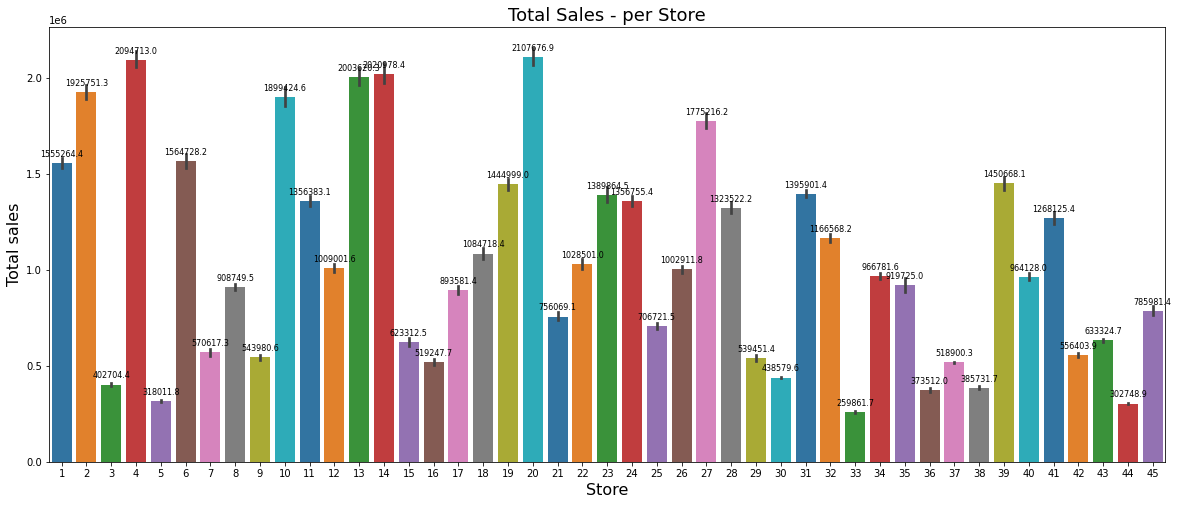

In [ ]:
# Weekly sales by store
plt.figure(figsize=(20,8))
splot=sns.barplot(Overall_stores_sales['Store'], Overall_stores_sales['Weekly_Sales'], palette='tab10')

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points',size=8)

plt.title('Total Sales - per Store', fontsize=18)
plt.ylabel('Total sales', fontsize=16)
plt.xlabel('Store', fontsize=16)
plt.show()

In [ ]:
train=pd.merge(train,stores,on="Store")
train.head(2)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Year,Month,Day,Week,Type,Size
0,1,1,2010-02-05,24924.50,False,2010,2,5,5.0,A,151315
1,1,1,2010-02-12,46039.49,True,2010,2,12,6.0,A,151315


In [ ]:
store_type=train.groupby("Type")["Weekly_Sales"].mean().to_frame("Total_sales")
store_type.head()

,Total_sales
Type,
A,20099.568043
B,12237.075977
C,9519.532538


In [ ]:
pie_plot2=train.groupby("Type")["Size"].mean().to_frame("sum")
pie_plot3=stores.groupby("Type")["Store"].count().to_frame("sum")

trace1 = go.Pie(
     values=store_type["Total_sales"],
     labels=store_type.index,
     domain=dict(x=[0, 0.33]),
     name="Total_sales",
     hoverinfo="label+percent+name",
     title="Total sales of Stores based on their type",

)
trace2 = go.Pie(
     values=pie_plot2["sum"],
     labels=pie_plot2.index,
     domain=dict(x=[0.33, 0.66]),
     name="Size",
     hoverinfo="label+percent+name",
     title="Total size of Stores based on their type",
)
trace3 = go.Pie(
     values=pie_plot3["sum"],
     labels=pie_plot3.index,
     domain=dict(x=[0.66, 1.0]),
     name="Count",
     hoverinfo="label+percent+name",
     title="Number of Stores in each category",
)

layout = go.Layout(title="Types of stores",)
data = [trace1, trace2,trace3]
fig = go.Figure(data=data, layout=layout)
py.plot(fig, filename='simple-pie-subplot')
iplot(fig)


In [ ]:
train.isnull().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
Year            0
Month           0
Day             0
Week            0
Type            0
Size            0
dtype: int64

In [ ]:
manual_dummy = {'A':3, 'B':2, 'C':1}
train['Type_num'] = train.Type.map(manual_dummy)
train=train.drop("Type",axis=1)

train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Year,Month,Day,Week,Size,Type_num
0,1,1,2010-02-05,24924.50,False,2010,2,5,5.0,151315,3
1,1,1,2010-02-12,46039.49,True,2010,2,12,6.0,151315,3
2,1,1,2010-02-19,41595.55,False,2010,2,19,7.0,151315,3
3,1,1,2010-02-26,19403.54,False,2010,2,26,8.0,151315,3
4,1,1,2010-03-05,21827.90,False,2010,3,5,9.0,151315,3


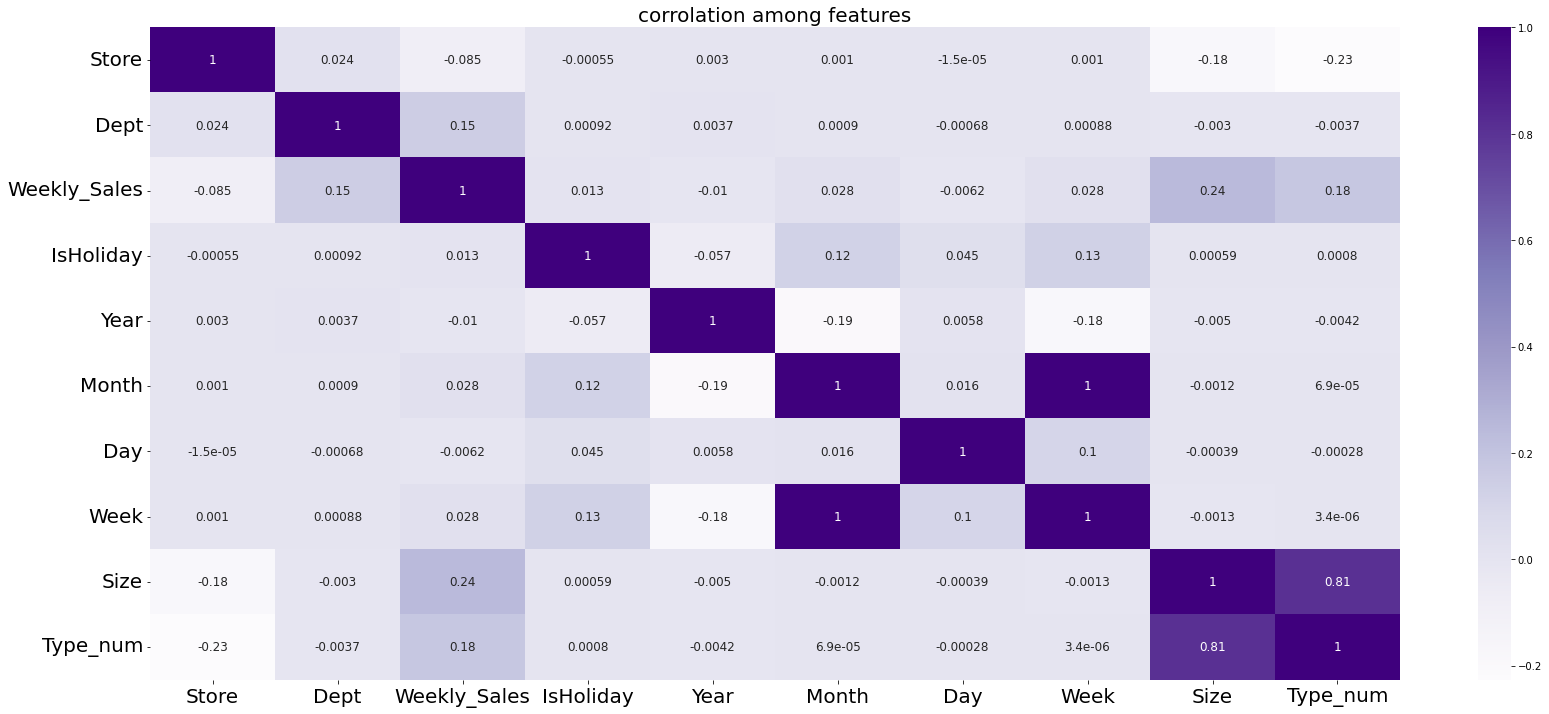

In [ ]:
plt.figure(figsize=(28,12))
plt.xticks( fontsize=20)
plt.yticks( fontsize=20)

sns.heatmap(train.corr(), cmap='Purples', annot=True, annot_kws={'size':12})
plt.title('corrolation among features', fontsize=20);

In [ ]:
train=train.drop(['Date','Month', 'Day' ], axis=1)
train.head(2)

,Store,Dept,Weekly_Sales,IsHoliday,Year,Week,Size,Type_num
0,1,1,24924.50,False,2010,5.0,151315,3
1,1,1,46039.49,True,2010,6.0,151315,3


In [ ]:
test=pd.merge(test,stores,on="Store")
test.head(2)

,Store,Dept,Date,IsHoliday,Type,Size
0,1,1,2012-11-02,False,A,151315
1,1,1,2012-11-09,False,A,151315


In [ ]:
test['Date'] = pd.to_datetime(test['Date'])
test['Week'] = (test.Date.dt.isocalendar().week)*1.0   
test['Year'] = test.Date.dt.year
test=test.drop("Date",axis=1)
manual_dummy = {'A':3, 'B':2, 'C':1}
test['Type_num'] = test.Type.map(manual_dummy)
test=test.drop("Type",axis=1)

test.head(2)


,Store,Dept,IsHoliday,Size,Week,Year,Type_num
0,1,1,False,151315,44.0,2012,3
1,1,1,False,151315,45.0,2012,3


In [ ]:
train.columns

Index(['Store', 'Dept', 'Weekly_Sales', 'IsHoliday', 'Year', 'Week', 'Size',
       'Type_num'],
      dtype='object')

In [ ]:
test=test[['Store', 'Dept', 'IsHoliday', 'Year', 'Week', 'Size','Type_num']]
test.head(2)

,Store,Dept,IsHoliday,Year,Week,Size,Type_num
0,1,1,False,2012,44.0,151315,3
1,1,1,False,2012,45.0,151315,3


# **MinMaxScaler Transform**

In [ ]:
X = train.drop("Weekly_Sales",axis=1)
y = train['Weekly_Sales']
scaler = MinMaxScaler()
X= scaler.fit_transform(X)
test = scaler.transform(test)

## **Machine Learning Modeling**



# **1-XGBoost**

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train.shape, X_test.shape,y_train.shape,y_test.shape

((295099, 7), (126471, 7), (295099,), (126471,))

In [ ]:
#Training

model1 = XGBRegressor(random_state=42, n_jobs=-1)
model1.fit(X_train, y_train)
model1_train_preds = model1.predict(X_train)
model1_test_preds = model1.predict(X_test)

[21:38:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
print('Mean Absolute Error for train (MAE): ', metrics.mean_absolute_error(y_train, model1_train_preds))
print('Mean Absolute Error for test(MAE) :', metrics.mean_absolute_error(y_test, model1_test_preds))



Mean Absolute Error for train (MAE):  6849.492972748777
Mean Absolute Error for test(MAE) : 6927.395442120562


In [ ]:
#Testing
forcasting_df['Weekly_Sales_XGB1']=model1.predict(test)
forcasting_df.head()

,Store,Dept,Date,IsHoliday,Weekly_Sales_XGB1
0,1,1,2012-11-02,False,25300.494141
1,1,1,2012-11-09,False,25300.494141
2,1,1,2012-11-16,False,25300.494141
3,1,1,2012-11-23,True,31682.855469
4,1,1,2012-11-30,False,31682.855469


In [ ]:
#Performance Assessment

forcasting_train['Weekly_Sales_XGB1']=model1.predict(X)

daily_sales_XGB1 = forcasting_train.groupby('Date', as_index=False)['Weekly_Sales_XGB1'].sum()

plot1 = go.Scatter(x=Overall_Weekly_sales['Date'], y=Overall_Weekly_sales['Weekly_Sales'],name="Training set")
layout = go.Layout(title='Weekly sales', xaxis=dict(title='Date'), yaxis=dict(title='Weekly_Sales'))

plot2 = go.Scatter(x=daily_sales_XGB1['Date'], y=daily_sales_XGB1['Weekly_Sales_XGB1'],name="XGBoost1")
layout = go.Layout(title='XGBoost Model Forcasting with initial parameters', xaxis=dict(title='Date'), yaxis=dict(title='Weekly_Sales_XGB1'))

fig = go.Figure(data=[plot1,plot2], layout=layout)
iplot(fig)

In [ ]:
# To explore the time series data first we need to aggregate the sales by week
daily_sales_XGB1 = forcasting_df.groupby('Date', as_index=False)['Weekly_Sales_XGB1'].sum()
store_daily_sales_XGB1  = forcasting_df.groupby(['Store', 'Date'], as_index=False)['Weekly_Sales_XGB1'].sum()

In [ ]:
# Overall Weekly sales
plot1 = go.Scatter(x=Overall_Weekly_sales['Date'], y=Overall_Weekly_sales['Weekly_Sales'],name="Training set")
layout = go.Layout(title='Weekly sales', xaxis=dict(title='Date'), yaxis=dict(title='Weekly_Sales'))

plot2 = go.Scatter(x=daily_sales_XGB1['Date'], y=daily_sales_XGB1['Weekly_Sales_XGB1'],name="XGBoost1")
layout = go.Layout(title='XGBoost Model Forcasting with initial parameters', xaxis=dict(title='Date'), yaxis=dict(title='Weekly_Sales_XGB1'))
fig = go.Figure(data=[plot1,plot2], layout=layout)
iplot(fig)

# **XGBoost Hyper Parameter tunning**

In [ ]:
def xgb_hyper_parameter(param_name, param_values):
    test_pred_error= []
    for value in param_values:
        params = {param_name: value}
        model2 = XGBRegressor(random_state=42, n_jobs=-1, **params).fit(X_train, y_train)
        model2_test_preds = model2.predict(X_test)
        MAPE_test_pred = metrics.mean_absolute_percentage_error(y_test, model2_test_preds)
        test_pred_error.append(MAPE_test_pred)
    min_MAPE=min(test_pred_error)
    best_param = param_values[test_pred_error.index(min_MAPE)]
    return best_param

In [ ]:
hyper_n_estimators=xgb_hyper_parameter('n_estimators', [200, 300, 400, 500])
hyper_max_depth=xgb_hyper_parameter('max_depth', [5, 10, 15, 20])
hyper_min_depth=xgb_hyper_parameter('min_child_weight', [5,6,7,8])
hyper_learning_rate=xgb_hyper_parameter('learning_rate', [0.4, 0.6, 0.8, 0.9])
hyper_subsample=xgb_hyper_parameter('subsample', [0.7,0.8, 0.9,1.0])
hyper_colsample=xgb_hyper_parameter('colsample_bytree', [0.7,0.8, 0.9,1.0])


[21:38:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:38:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:39:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:39:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:40:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:40:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:41:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[21:42:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

# Best Parameters

In [ ]:
print(' n_estimators :',hyper_n_estimators,"\n",
      "max_depth :", hyper_max_depth,"\n", 
      "min_child_weight :",hyper_min_depth,"\n",
      "learning_rate :",hyper_learning_rate,"\n",
      "subsample :",hyper_subsample,"\n",
      "colsample_bytree :",hyper_colsample)

 n_estimators : 500 
 max_depth : 20 
 min_child_weight : 5 
 learning_rate : 0.9 
 subsample : 0.9 
 colsample_bytree : 1.0


In [ ]:
model2 = XGBRegressor(random_state=42, n_jobs=-1, n_estimators=hyper_n_estimators, max_depth=hyper_max_depth, learning_rate=hyper_learning_rate,
                      min_child_weight=hyper_min_depth , subsample=hyper_subsample , colsample_bytree=hyper_colsample)
model2.fit(X_train, y_train)
model2_train_preds = model2.predict(X_train)
model2_test_preds = model2.predict(X_test)

[21:46:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:

print('Mean Absolute Error for train (MAE): ', metrics.mean_absolute_error(y_train, model2_train_preds))
print('Mean Absolute Error for test(MAE) :', metrics.mean_absolute_error(y_test, model2_test_preds))


Mean Absolute Error for train (MAE):  0.39893856097018854
Mean Absolute Error for test(MAE) : 1684.2046400310505


In [ ]:

forcasting_train['Weekly_Sales_XGB2']=model2.predict(X)
daily_sales_XGB2 = forcasting_train.groupby('Date', as_index=False)['Weekly_Sales_XGB2'].sum()

plot1 = go.Scatter(x=Overall_Weekly_sales['Date'], y=Overall_Weekly_sales['Weekly_Sales'],name="Training set")
layout = go.Layout(title='Weekly sales', xaxis=dict(title='Date'), yaxis=dict(title='Weekly_Sales'))

plot2 = go.Scatter(x=daily_sales_XGB2['Date'], y=daily_sales_XGB2['Weekly_Sales_XGB2'],name="XGBoost2")
layout = go.Layout(title='XGBoost Model Forcasting with hyper parameters', xaxis=dict(title='Date'), yaxis=dict(title='Weekly_Sales_XGB2'))

fig = go.Figure(data=[plot1,plot2], layout=layout)
iplot(fig)

In [ ]:
#Forcasting test set with xgboost hyper tunning

forcasting_df['Weekly_Sales_XGB2']=model2.predict(test)
forcasting_df.head()

,Store,Dept,Date,IsHoliday,Weekly_Sales_XGB1,Weekly_Sales_XGB2
0,1,1,2012-11-02,False,25300.494141,33412.070312
1,1,1,2012-11-09,False,25300.494141,17766.255859
2,1,1,2012-11-16,False,25300.494141,18617.652344
3,1,1,2012-11-23,True,31682.855469,20963.351562
4,1,1,2012-11-30,False,31682.855469,24738.539062


In [ ]:
# To explore the time series data first we need to aggregate the sales by week
daily_sales_XGB = forcasting_df.groupby('Date', as_index=False)['Weekly_Sales_XGB2'].sum()
store_daily_sales_XGB  = forcasting_df.groupby(['Store', 'Date'], as_index=False)['Weekly_Sales_XGB2'].sum()

In [ ]:
# Overall Weekly sales
sales_plot_XGB = go.Scatter(x=daily_sales_XGB['Date'], y=daily_sales_XGB['Weekly_Sales_XGB2'])
layout = go.Layout(title='XGBoost Model Forcasting with hyperparameter', xaxis=dict(title='Date'), yaxis=dict(title='Weekly_Sales_XGB2'))
fig = go.Figure(data=[sales_plot_XGB], layout=layout)
iplot(fig)

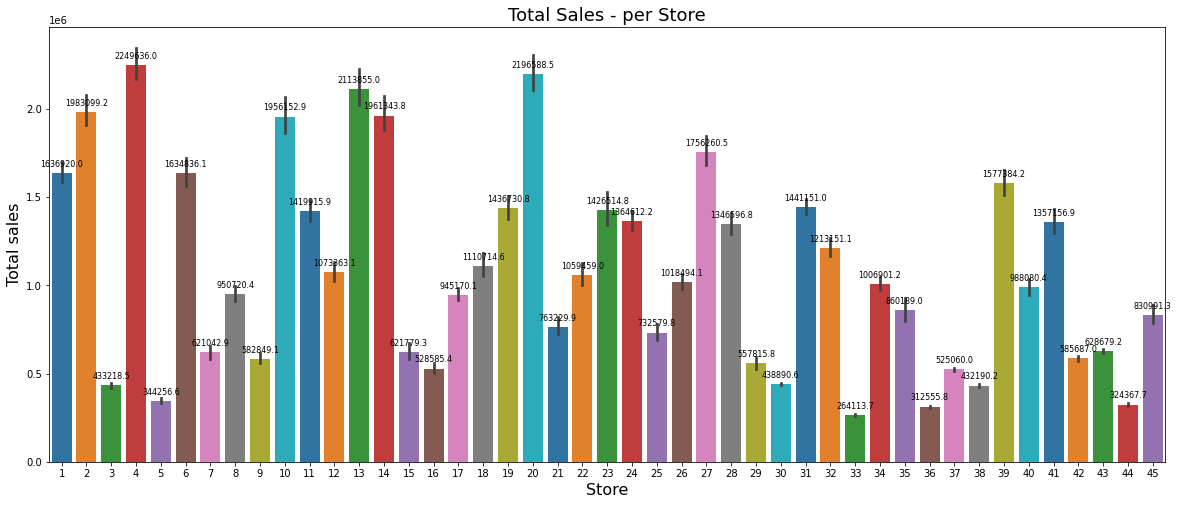

In [ ]:
plt.figure(figsize=(20,8))
splot=sns.barplot(store_daily_sales_XGB['Store'], store_daily_sales_XGB['Weekly_Sales_XGB2'], palette='tab10')

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points',size=8)

plt.title('Total Sales - per Store', fontsize=18)
plt.ylabel('Total sales', fontsize=16)
plt.xlabel('Store', fontsize=16)
plt.show()

In [ ]:
plot1 = go.Scatter(x=Overall_Weekly_sales['Date'], y=Overall_Weekly_sales['Weekly_Sales'],name="Training set")
layout = go.Layout(title='Weekly sales', xaxis=dict(title='Date'), yaxis=dict(title='Weekly_Sales'))

plot2 = go.Scatter(x=daily_sales_XGB1['Date'], y=daily_sales_XGB1['Weekly_Sales_XGB1'],name="XGBoost1")
layout = go.Layout(title='XGBoost Model Forcasting with initial parameters', xaxis=dict(title='Date'), yaxis=dict(title='Weekly_Sales_XGB1'))

plot3 = go.Scatter(x=daily_sales_XGB['Date'], y=daily_sales_XGB['Weekly_Sales_XGB2'],name="XGBoost2")
layout = go.Layout(title='Weekly_Sales_XGB2', xaxis=dict(title='Date'), yaxis=dict(title='Weekly_Sales_XGB2'))

fig = go.Figure(data=[plot1,plot2,plot3], layout=layout)
iplot(fig)

# **2- Random Forest Model**

In [ ]:

model_rf1= RandomForestRegressor(max_depth=2, random_state=0)
model_rf1.fit(X_train, y_train)
RF1_train_pred=model_rf1.predict(X_train)
RF1_test_preds = model_rf1.predict(X_test)

In [ ]:

print('Mean Absolute Error for train (MAE): ', metrics.mean_absolute_error(y_train, RF1_train_pred))
print('Mean Absolute Error for test (MAE) :', metrics.mean_absolute_error(y_test, RF1_test_preds))


Mean Absolute Error for train (MAE):  12875.329302792155
Mean Absolute Error for test (MAE) : 12885.029334599303


In [ ]:
forcasting_train['Weekly_Sales_RF1']=model_rf1.predict(X)

# To explore the time series data first we need to aggregate the sales by week
daily_sales_rf1 = forcasting_train.groupby('Date', as_index=False)['Weekly_Sales_RF1'].sum()
# Overall Weekly sales
plot1 = go.Scatter(x=Overall_Weekly_sales['Date'], y=Overall_Weekly_sales['Weekly_Sales'],name="Training set")
layout = go.Layout(title='Weekly sales', xaxis=dict(title='Date'), yaxis=dict(title='Weekly_Sales'))

plot2 = go.Scatter(x=daily_sales_rf1['Date'], y=daily_sales_rf1['Weekly_Sales_RF1'],name="Weekly_Sales_RF1")
layout = go.Layout(title='rf1 Forcasting with initial parameters', xaxis=dict(title='Date'), yaxis=dict(title='Weekly_Sales_RF1'))
fig = go.Figure(data=[plot1,plot2], layout=layout)
iplot(fig)

In [ ]:
forcasting_df['Weekly_Sales_RF1']=model_rf1.predict(test)
forcasting_df.head()

,Store,Dept,Date,IsHoliday,Weekly_Sales_XGB1,Weekly_Sales_XGB2,Weekly_Sales_RF1
0,1,1,2012-11-02,False,25300.494141,33412.070312,20793.374716
1,1,1,2012-11-09,False,25300.494141,17766.255859,20793.374716
2,1,1,2012-11-16,False,25300.494141,18617.652344,20793.374716
3,1,1,2012-11-23,True,31682.855469,20963.351562,20793.374716
4,1,1,2012-11-30,False,31682.855469,24738.539062,20793.374716


In [ ]:
# To explore the time series data first we need to aggregate the sales by week
daily_sales_RF1 = forcasting_df.groupby('Date', as_index=False)['Weekly_Sales_RF1'].sum()
store_daily_sales_RF1  = forcasting_df.groupby(['Store', 'Date'], as_index=False)['Weekly_Sales_RF1'].sum()

In [ ]:
plot1 = go.Scatter(x=Overall_Weekly_sales['Date'], y=Overall_Weekly_sales['Weekly_Sales'],name="Training set")
layout = go.Layout(title='Weekly sales', xaxis=dict(title='Date'), yaxis=dict(title='Weekly_Sales'))

plot2 = go.Scatter(x=daily_sales_RF1['Date'], y=daily_sales_RF1['Weekly_Sales_RF1'],name="RandomForest1")
layout = go.Layout(title='Weekly Sales RandomForest1', xaxis=dict(title='Date'), yaxis=dict(title='Weekly_Sales_RF1'))

fig = go.Figure(data=[plot1,plot2], layout=layout)
iplot(fig)

# **Random Forest with Hyper Parameter**

In [ ]:
def RFM_hyper_params(param_name, param_values):
    Test_err = []
    for value in param_values:
        params = {param_name: value}
        model = RandomForestRegressor(max_depth=2, random_state=0,**params).fit(X_train, y_train)
        predected_test=model.predict(X_test)
        MAPE_test_pred = metrics.mean_absolute_percentage_error(y_test, predected_test)
        Test_err.append(MAPE_test_pred)
    min_error=min(Test_err)
    best_param = param_values[Test_err.index(min_error)]
    return best_param

In [ ]:
hyper_n_estimators_rf=RFM_hyper_params('n_estimators', range(50,60,2))
hyper_max_features_rf=RFM_hyper_params('max_features', [0.1,0.25,0.50,0.75])


**Best parameters for Random Forest Model**

In [ ]:
print(' n_estimators :',hyper_n_estimators_rf,"\n",
      "max_features :",hyper_max_features_rf)

 n_estimators : 54 
 max_features : 0.75


In [ ]:
model_rf2= RandomForestRegressor(n_estimators=hyper_n_estimators_rf, max_depth=25, max_features=hyper_max_features_rf,
                           min_samples_split=3, min_samples_leaf=1)
model_rf2.fit(X_train, y_train)
rf2_train_pred=model_rf2.predict(X_train)
rf2_test_preds = model_rf2.predict(X_test)


In [ ]:
print('Mean Absolute Error for train (MAE): ', metrics.mean_absolute_error(y_train, rf2_train_pred))
print('Mean Absolute Error for test (MAE) :', metrics.mean_absolute_error(y_test, rf2_test_preds))


Mean Absolute Error for train (MAE):  672.3623862954305
Mean Absolute Error for test (MAE) : 1433.4466752852504


In [ ]:
forcasting_train['Weekly_Sales_RF2']=model_rf2.predict(X)
# To explore the time series data first we need to aggregate the sales by week
daily_sales_rf2 = forcasting_train.groupby('Date', as_index=False)['Weekly_Sales_RF2'].sum()
# Overall Weekly sales
plot1 = go.Scatter(x=Overall_Weekly_sales['Date'], y=Overall_Weekly_sales['Weekly_Sales'],name="Training set")
layout = go.Layout(title='Weekly sales', xaxis=dict(title='Date'), yaxis=dict(title='Weekly_Sales'))

plot2 = go.Scatter(x=daily_sales_rf2['Date'], y=daily_sales_rf2['Weekly_Sales_RF2'],name="Weekly_Sales_RF2")
layout = go.Layout(title='rf2 Forcasting with hyper parameters', xaxis=dict(title='Date'), yaxis=dict(title='Weekly_Sales_RF2'))
fig = go.Figure(data=[plot1,plot2], layout=layout)
iplot(fig)

In [ ]:
forcasting_df['Weekly_Sales_RF2']=model_rf2.predict(test)
forcasting_df.head()

,Store,Dept,Date,IsHoliday,Weekly_Sales_XGB1,Weekly_Sales_XGB2,Weekly_Sales_RF1,Weekly_Sales_RF2
0,1,1,2012-11-02,False,25300.494141,33412.070312,20793.374716,28748.186873
1,1,1,2012-11-09,False,25300.494141,17766.255859,20793.374716,20449.413077
2,1,1,2012-11-16,False,25300.494141,18617.652344,20793.374716,20336.574355
3,1,1,2012-11-23,True,31682.855469,20963.351562,20793.374716,20867.531006
4,1,1,2012-11-30,False,31682.855469,24738.539062,20793.374716,23528.539454


In [ ]:
# To explore the time series data first we need to aggregate the sales by week
daily_sales_RF2 = forcasting_df.groupby('Date', as_index=False)['Weekly_Sales_RF2'].sum()
store_daily_sales_RF2  = forcasting_df.groupby(['Store', 'Date'], as_index=False)['Weekly_Sales_RF2'].sum()

In [ ]:
plot1 = go.Scatter(x=Overall_Weekly_sales['Date'], y=Overall_Weekly_sales['Weekly_Sales'],name="Training set")
layout = go.Layout(title='Weekly sales', xaxis=dict(title='Date'), yaxis=dict(title='Weekly_Sales'))

plot2 = go.Scatter(x=daily_sales_RF1['Date'], y=daily_sales_RF1['Weekly_Sales_RF1'],name="RandomForest1")
layout = go.Layout(title='Weekly Sales RandomForest1', xaxis=dict(title='Date'), yaxis=dict(title='Weekly_Sales_RF1'))

plot3 = go.Scatter(x=daily_sales_RF2['Date'], y=daily_sales_RF2['Weekly_Sales_RF2'],name="RandomForest2")
layout = go.Layout(title='Weekly Sales RandomTorest', xaxis=dict(title='Date'), yaxis=dict(title='Weekly_Sales_RF2'))

fig = go.Figure(data=[plot1,plot2,plot3], layout=layout)
iplot(fig)

In [ ]:
forcasting_train['Weekly_Sales_RF2']=model_rf2.predict(X)


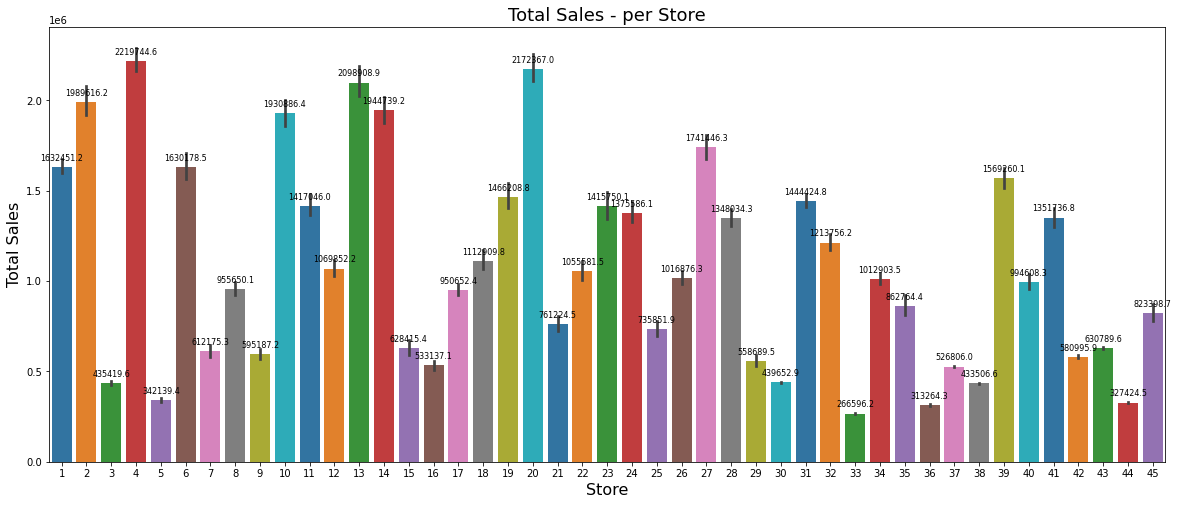

In [ ]:
plt.figure(figsize=(20,8))
splot=sns.barplot(store_daily_sales_RF2['Store'], store_daily_sales_RF2['Weekly_Sales_RF2'], palette='tab10')

for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points',size=8)

plt.title('Total Sales - per Store', fontsize=18)
plt.ylabel('Total Sales', fontsize=16)
plt.xlabel('Store', fontsize=16)
plt.show()

In [ ]:
plot1 = go.Scatter(x=Overall_Weekly_sales['Date'], y=Overall_Weekly_sales['Weekly_Sales'],name="Training set")
layout = go.Layout(title='Weekly sales', xaxis=dict(title='Date'), yaxis=dict(title='Weekly_Sales'))

plot2 = go.Scatter(x=daily_sales_XGB['Date'], y=daily_sales_XGB['Weekly_Sales_XGB2'],name="XGBoost2")
layout = go.Layout(title='Weekly_Sales_XGB2', xaxis=dict(title='Date'), yaxis=dict(title='Weekly_Sales_XGBoost2'))


plot3 = go.Scatter(x=daily_sales_RF2['Date'], y=daily_sales_RF2['Weekly_Sales_RF2'],name="RandomForest2")
layout = go.Layout(title='Weekly Sales RandomTorest', xaxis=dict(title='Date'), yaxis=dict(title='Weekly_Sales_RF2'))


fig = go.Figure(data=[plot1,plot2,plot3], layout=layout)
iplot(fig)